# **Introduction**
The goal of this program is to reduce the number of facial landmarks and use LSTM network to detect if someone is lying.

This program is built on top of our method 2 model: https://colab.research.google.com/drive/17wdVPuG3W0-RzZMYR5VfvXKmay1uPJun

There are signs in the the movement of eyes or iris that can indicate a person may be potentially lying or stressful


*   **Dialated Pupils:** indicate heightened stress or cognitive load, which may occur when someone is lying
*   **Frequent movement of eyes:** signs of nervousness or cognitive strain, potentially indicating attempts to avoid direct eye contact or manage anxiety associated with deception.
*   **Execssive Blinking:** --> can suggest discomfort or stress, which might be present when someone is being untruthful.



Code Reference:
*   **Eye:**  https://github.com/Asadullah-Dal17/Eyes-Position-Estimator-Mediapipe/blob/master/Eye_Tracking_part2/main.py
*   **Iris:**  https://github.com/Asadullah-Dal17/Iris-python/blob/master/Mediapip-Eyes-tracking-master%2030.05.2022/eyes_tracking/rastreamento-iris.py



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import glob
from pathlib import Path
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import math


# Check for GPU availability and set device
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2-Layer MLP
Exact code from method 2 modelling

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_num, output_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=layer_num, batch_first=True)
        self.dropout = nn.Dropout(0.20)
        self.linear = nn.Linear(200, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.linear(self.dropout(out))
        out = self.sigmoid(out)
        return out



# **Getting the Classified Output Y**

In [ ]:
EXCEL_DATA_PATH  = '/content/drive/MyDrive/Deception_Detection/Datasets/MU3D-Package/MU3D Codebook.xlsx'
FOLDER = '/content/drive/MyDrive/Deception_Detection/Datasets/MU3D-Package'
SAVE_NPY_PATH = FOLDER + "/" + "NPY_FILES(240frames)"

df = pd.read_excel(EXCEL_DATA_PATH, sheet_name="Video-Level Data")

# Iterate through each row of the Excel file
truthfulness = {}
for index, row in df.iterrows():
  truthfulness[row["VideoID"]] = row["Veracity"]

# 0 indicates lie, 1 indicates truth

# **Getting the Input X**


In [ ]:
RIGHT_EYE=[ 33, 7, 163, 144, 145, 153, 154, 155, 133, 173, 157, 158, 159, 160, 161 , 246 ]
LEFT_EYE =[ 362, 382, 381, 380, 374, 373, 390, 249, 263, 466, 388, 387, 386, 385,384, 398 ]

LEFT_IRIS = [474, 475, 476, 477]
RIGHT_IRIS = [469, 470, 471, 472]

L_H_LEFT = [33]     # right eye most right reference point
L_H_RIGHT = [133]   # right eye most left reference point
R_H_LEFT = [362]    # left eye most right reference point
R_H_RIGHT = [263]   # left eye most left reference point

## Functions

#### Convert a numpy array and convert it into chunks
We have 320 video. Each video is represented by a (240, 478, 2) array. We will divide them into 8 chunks. So each chunk will be a (30, 956) array.

In [ ]:
def npy_to_npychunks(data):

  chunk_size = 30
  num_chunks = data.shape[0] // chunk_size

  # Split the array into chunks
  chunks = np.array_split(data[:num_chunks * 30], num_chunks)

  # Convert list of arrays to a single numpy array
  array = np.stack(chunks)
  return array

#### Calculating Euclaidean distance

In [ ]:
# Euclaidean distance
def euclideanDistance(point, point1):
    x, y = point
    x1, y1 = point1
    distance = np.sqrt((x1 - x)**2 + (y1 - y)**2)
    return distance

#### Calculating Blink Ratio

In [ ]:
# Blink Ratio
def blinkRatio(right_eye_landmarks, left_eye_landmarks):
    ratios = []
    # Loop through each frame of landmarks
    for rh_landmarks, lh_landmarks in zip(right_eye_landmarks, left_eye_landmarks):
        # Right eye
        # Horizontal line
        rh_right = rh_landmarks[0]
        rh_left = rh_landmarks[8]
        # Vertical line
        rv_top = rh_landmarks[12]
        rv_bottom = rh_landmarks[4]

        # Left eye
        # Horizontal line
        lh_right = lh_landmarks[0]
        lh_left = lh_landmarks[8]
        # Vertical line
        lv_top = lh_landmarks[12]
        lv_bottom = lh_landmarks[4]

        # Calculate distances
        rhDistance = euclideanDistance(rh_right, rh_left)
        rvDistance = euclideanDistance(rv_top, rv_bottom)
        lhDistance = euclideanDistance(lh_right, lh_left)
        lvDistance = euclideanDistance(lv_top, lv_bottom)

        # Calculate ratios
        reRatio = rhDistance / rvDistance
        leRatio = lhDistance / lvDistance

        # Calculate average ratio
        ratio = (reRatio + leRatio) / 2
        ratios.append(ratio)

    return np.array(ratios)


### Adding another dimension

In [ ]:
def add_dimension(original_array, dimension_to_add):
  reshaped_array = dimension_to_add[:, np.newaxis, np.newaxis] # Reshape the blink ratio array to match the size of the combined landmarks along axis 1 and axis 2
  reshaped_array = np.repeat(reshaped_array, original_array.shape[1], axis=1) # Repeat the reshaped_ratioarray along axis 1 to match the size of the combined landmarks
  combined_array = np.concatenate((original_array, reshaped_array), axis=2) # Concatenate the repeated blink ratio array with the combined landmarks array along the last dimension
  return combined_array

## Eyes

### Left and Right Eye Facial Landmarks each with  XY coordinates

In [ ]:
import random

input_list_T = []
input_list_F = []
output_list_T = []
output_list_F = []

loop = 1
for file_path in glob.glob(SAVE_NPY_PATH+"/*", recursive = True):
  # Y Value
  output = truthfulness[Path(file_path).stem]

  # X Value
  array = np.load(file_path)
  # print("Original shape of array: ", array.shape)

  right_eye_landmarks = array[:, RIGHT_EYE, :]
  left_eye_landmarks = array[:, LEFT_EYE, :]
  combined_landmarks = np.concatenate((right_eye_landmarks, left_eye_landmarks), axis=1)
  print("Combimed shape of an array: ",combined_landmarks.shape)

  array = combined_landmarks.reshape(240, -1)

  array = npy_to_npychunks(array)
  print("Chunk shape array: ", array.shape)
  num_chunks = array.shape[0]

  if output == 1:
    input_list_T.append(array)
    output_list_T += [output]*num_chunks
  else:
    input_list_F.append(array)
    output_list_F += [output]*num_chunks
  print(f"# of Videos Processed: {loop}")
  loop += 1


X_T = np.vstack(input_list_T)
X_F = np.vstack(input_list_F)
Y_T = np.array(output_list_T).reshape(-1,1)
Y_F = np.array(output_list_F).reshape(-1,1)



X_T = torch.from_numpy(X_T).to(device)
X_F = torch.from_numpy(X_F).to(device)
Y_T = torch.from_numpy(Y_T).to(device)
Y_F = torch.from_numpy(Y_F).to(device)

X_T = X_T.float()
X_F = X_F.float()
Y_T = Y_T.float()
Y_F = Y_F.float()

print("X_T.shape", X_T.shape)
print("X_F.shape", X_F.shape)
print("Y_T.shape", Y_T.shape)
print("Y_F.shape", Y_F.shape)

(240, 478, 2)
(240, 32, 2)
(8, 30, 64)
# of Videos Processed: 1
(240, 478, 2)
(240, 32, 2)
(8, 30, 64)
# of Videos Processed: 2
(240, 478, 2)
(240, 32, 2)
(8, 30, 64)
# of Videos Processed: 3
(240, 478, 2)
(240, 32, 2)
(8, 30, 64)
# of Videos Processed: 4
(240, 478, 2)
(240, 32, 2)
(8, 30, 64)
# of Videos Processed: 5
(240, 478, 2)
(240, 32, 2)
(8, 30, 64)
# of Videos Processed: 6
(240, 478, 2)
(240, 32, 2)
(8, 30, 64)
# of Videos Processed: 7
(240, 478, 2)
(240, 32, 2)
(8, 30, 64)
# of Videos Processed: 8
(240, 478, 2)
(240, 32, 2)
(8, 30, 64)
# of Videos Processed: 9
(240, 478, 2)
(240, 32, 2)
(8, 30, 64)
# of Videos Processed: 10
(240, 478, 2)
(240, 32, 2)
(8, 30, 64)
# of Videos Processed: 11
(240, 478, 2)
(240, 32, 2)
(8, 30, 64)
# of Videos Processed: 12
(240, 478, 2)
(240, 32, 2)
(8, 30, 64)
# of Videos Processed: 13
(240, 478, 2)
(240, 32, 2)
(8, 30, 64)
# of Videos Processed: 14
(240, 478, 2)
(240, 32, 2)
(8, 30, 64)
# of Videos Processed: 15
(240, 478, 2)
(240, 32, 2)
(8, 30,

In [ ]:
import torch.utils.data as data

# Split the shuffled data into 80% Training, 20% Testing
train_dataset_T, val_dataset_T = torch.utils.data.random_split(data.TensorDataset(X_T, Y_T), [0.8, 0.2])
train_dataset_F, val_dataset_F = torch.utils.data.random_split(data.TensorDataset(X_F, Y_F), [0.8, 0.2])

train_dataset = data.ConcatDataset([train_dataset_T, train_dataset_F])
val_dataset = data.ConcatDataset([val_dataset_T, val_dataset_F])

print("Training Dataset Size:", len(train_dataset))
print("Testing Dataset Size:", len(val_dataset))
print()

train_loader = data.DataLoader(train_dataset, batch_size=50, shuffle=True)

total_train_samples = len(train_dataset)
count_train_ones = sum(1 for _, label in train_dataset if label == 1)
percentage_train_ones = (count_train_ones / total_train_samples) * 100
print("Percentage of Y that are Truths in train_dataset:", percentage_train_ones)


test_loader = data.DataLoader(val_dataset, batch_size=1, shuffle=False)

total_val_samples = len(val_dataset)
count_val_ones = sum(1 for _, label in val_dataset if label == 1)
percentage_val_ones = (count_val_ones / total_val_samples) * 100
print("Percentage of Y that are Truths in val_dataset:", percentage_val_ones)


X_train_all = []
Y_train_all = []


# Iterate over the train_loader to accumulate the entire dataset
for X_train, Y_train in train_loader:
    X_train_all.append(X_train)
    Y_train_all.append(Y_train)

X_test_all = []
Y_test_all = []

for X_test, Y_test in test_loader:
    X_test_all.append(X_test)
    Y_test_all.append(Y_test)

X_test_all = torch.cat(X_test_all, dim=0).to(device)
Y_test_all = torch.cat(Y_test_all, dim=0).to(device)

X_train_all = torch.cat(X_train_all, dim=0).to(device)
Y_train_all = torch.cat(Y_train_all, dim=0).to(device)

Training Dataset Size: 2048
Testing Dataset Size: 512

Percentage of Y that are Truths in train_dataset: 50.0
Percentage of Y that are Truths in val_dataset: 50.0


-------------------
Epoch 0: train loss 0.6933, test loss 0.6933, train accuracy 0.5000, test accuracy 0.5000
-------------------
Epoch 1: train loss 0.6951, test loss 0.6954, train accuracy 0.5000, test accuracy 0.5000
-------------------
Epoch 2: train loss 0.6946, test loss 0.6940, train accuracy 0.5000, test accuracy 0.5000
-------------------
Epoch 3: train loss 0.6931, test loss 0.6929, train accuracy 0.4971, test accuracy 0.5254
-------------------
Epoch 4: train loss 0.6931, test loss 0.6929, train accuracy 0.4995, test accuracy 0.5000
-------------------
Epoch 5: train loss 0.6931, test loss 0.6929, train accuracy 0.4985, test accuracy 0.5000
-------------------
Epoch 6: train loss 0.6932, test loss 0.6929, train accuracy 0.5000, test accuracy 0.4980
-------------------
Epoch 7: train loss 0.6939, test loss 0.6935, train accuracy 0.5000, test accuracy 0.5000
-------------------
Epoch 8: train loss 0.6942, test loss 0.6944, train accuracy 0.5000, test accuracy 0.5000
----------

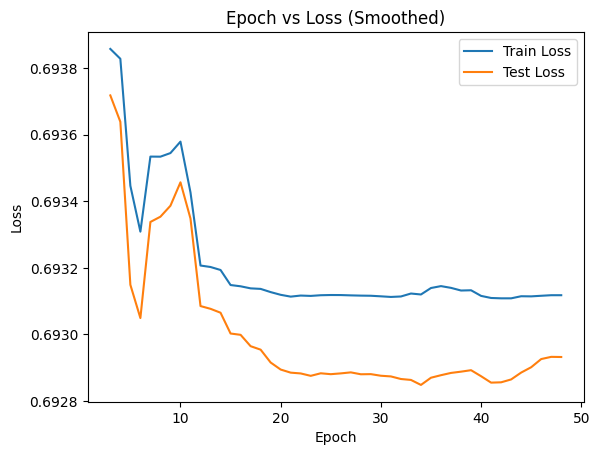

In [ ]:
import torch.utils.data as data
import matplotlib.pyplot as plt

# Lists to store training and test losses for each epoch
train_losses = []
test_losses = []

# Function to calculate accuracy
def accuracy(outputs, labels):
  preds = torch.round(outputs)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))


criterion = nn.BCELoss()
model = LSTMModel(input_dim=956, hidden_dim=200, layer_num=1, output_dim=1)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50

# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    epoch_acc = 0.0
    for X_batch, y_batch in train_loader:
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        print("-------------------")
        # Calculate accuracy on training set
        y_pred = model(X_train_all)
        train_loss = criterion(y_pred, Y_train_all)
        train_acc = accuracy(y_pred, Y_train_all)

        # Calculate accuracy on test set
        y_pred = model(X_test_all)
        test_loss = criterion(y_pred, Y_test_all)

        test_acc = accuracy(y_pred, Y_test_all)

    print("Epoch %d: train loss %.4f, test loss %.4f, train accuracy %.4f, test accuracy %.4f" % (epoch, train_loss, test_loss, train_acc, test_acc))

    # Append the losses to the lists
    train_losses.append(train_loss)
    test_losses.append(test_loss)

# Smooth the losses using a moving average
window_size = 5
train_losses_smoothed = np.convolve(train_losses, np.ones(window_size) / window_size, mode='valid')
test_losses_smoothed = np.convolve(test_losses, np.ones(window_size) / window_size, mode='valid')

# Plotting epoch vs training loss and test loss
epochs = range(window_size // 2 + 1, num_epochs - window_size // 2 + 1)
plt.plot(epochs, train_losses_smoothed, label='Train Loss')
plt.plot(epochs, test_losses_smoothed, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Loss (Smoothed)')
plt.legend()
plt.show()



### Adding Blink ratio

In [ ]:
import numpy as np

import random

input_list_T = []
input_list_F = []
output_list_T = []
output_list_F = []

loop = 1
for file_path in glob.glob(SAVE_NPY_PATH+"/*", recursive = True):
  # Y Value
  output = truthfulness[Path(file_path).stem]

  # X Value
  array = np.load(file_path)

  ## Filter to just eye landmarks
  right_eye_landmarks = array[:, RIGHT_EYE, :]
  left_eye_landmarks = array[:, LEFT_EYE, :]
  combined_landmarks = np.concatenate((right_eye_landmarks, left_eye_landmarks), axis=1)

  ratioarray = blinkRatio(right_eye_landmarks, left_eye_landmarks)
  combined_array = add_dimension(combined_landmarks, ratioarray)

  # ## We add ratio array as the third dimension
  # reshaped_ratioarray = ratioarray[:, np.newaxis, np.newaxis] # Reshape the blink ratio array to match the size of the combined landmarks along axis 1 and axis 2
  # repeated_ratioarray = np.repeat(reshaped_ratioarray, combined_landmarks.shape[1], axis=1) # Repeat the reshaped_ratioarray along axis 1 to match the size of the combined landmarks
  # combined_array = np.concatenate((combined_landmarks, repeated_ratioarray), axis=2) # Concatenate the repeated blink ratio array with the combined landmarks array along the last dimension

  print(combined_array.shape)
  array = combined_array.reshape(240, -1)
  print(array.shape)
  array = npy_to_npychunks(array)
  print(array.shape)
  num_chunks = array.shape[0]

  if output == 1:
    input_list_T.append(array)
    output_list_T += [output]*num_chunks
  else:
    input_list_F.append(array)
    output_list_F += [output]*num_chunks
  print(f"# of Videos Processed: {loop}")
  loop += 1


X_T = np.vstack(input_list_T)
X_F = np.vstack(input_list_F)
Y_T = np.array(output_list_T).reshape(-1,1)
Y_F = np.array(output_list_F).reshape(-1,1)



X_T = torch.from_numpy(X_T).to(device)
X_F = torch.from_numpy(X_F).to(device)
Y_T = torch.from_numpy(Y_T).to(device)
Y_F = torch.from_numpy(Y_F).to(device)

X_T = X_T.float()
X_F = X_F.float()
Y_T = Y_T.float()
Y_F = Y_F.float()

print("X_T.shape", X_T.shape)
print("X_F.shape", X_F.shape)
print("Y_T.shape", Y_T.shape)
print("Y_F.shape", Y_F.shape)

(240, 32, 3)
(240, 96)
(8, 30, 96)
# of Videos Processed: 1
(240, 32, 3)
(240, 96)
(8, 30, 96)
# of Videos Processed: 2
(240, 32, 3)
(240, 96)
(8, 30, 96)
# of Videos Processed: 3
(240, 32, 3)
(240, 96)
(8, 30, 96)
# of Videos Processed: 4
(240, 32, 3)
(240, 96)
(8, 30, 96)
# of Videos Processed: 5
(240, 32, 3)
(240, 96)
(8, 30, 96)
# of Videos Processed: 6
(240, 32, 3)
(240, 96)
(8, 30, 96)
# of Videos Processed: 7
(240, 32, 3)
(240, 96)
(8, 30, 96)
# of Videos Processed: 8
(240, 32, 3)
(240, 96)
(8, 30, 96)
# of Videos Processed: 9
(240, 32, 3)
(240, 96)
(8, 30, 96)
# of Videos Processed: 10
(240, 32, 3)
(240, 96)
(8, 30, 96)
# of Videos Processed: 11
(240, 32, 3)
(240, 96)
(8, 30, 96)
# of Videos Processed: 12
(240, 32, 3)
(240, 96)
(8, 30, 96)
# of Videos Processed: 13
(240, 32, 3)
(240, 96)
(8, 30, 96)
# of Videos Processed: 14
(240, 32, 3)
(240, 96)
(8, 30, 96)
# of Videos Processed: 15
(240, 32, 3)
(240, 96)
(8, 30, 96)
# of Videos Processed: 16
(240, 32, 3)
(240, 96)
(8, 30, 96

In [ ]:
import torch.utils.data as data

# Split the shuffled data into 80% Training, 20% Testing
train_dataset_T, val_dataset_T = torch.utils.data.random_split(data.TensorDataset(X_T, Y_T), [0.8, 0.2])
train_dataset_F, val_dataset_F = torch.utils.data.random_split(data.TensorDataset(X_F, Y_F), [0.8, 0.2])

train_dataset = data.ConcatDataset([train_dataset_T, train_dataset_F])
val_dataset = data.ConcatDataset([val_dataset_T, val_dataset_F])

print("Training Dataset Size:", len(train_dataset))
print("Testing Dataset Size:", len(val_dataset))
print()

train_loader = data.DataLoader(train_dataset, batch_size=50, shuffle=True)

total_train_samples = len(train_dataset)
count_train_ones = sum(1 for _, label in train_dataset if label == 1)
percentage_train_ones = (count_train_ones / total_train_samples) * 100
print("Percentage of Y that are Truths in train_dataset:", percentage_train_ones)


test_loader = data.DataLoader(val_dataset, batch_size=1, shuffle=False)

total_val_samples = len(val_dataset)
count_val_ones = sum(1 for _, label in val_dataset if label == 1)
percentage_val_ones = (count_val_ones / total_val_samples) * 100
print("Percentage of Y that are Truths in val_dataset:", percentage_val_ones)


X_train_all = []
Y_train_all = []


# Iterate over the train_loader to accumulate the entire dataset
for X_train, Y_train in train_loader:
    X_train_all.append(X_train)
    Y_train_all.append(Y_train)

X_test_all = []
Y_test_all = []

for X_test, Y_test in test_loader:
    X_test_all.append(X_test)
    Y_test_all.append(Y_test)

X_test_all = torch.cat(X_test_all, dim=0).to(device)
Y_test_all = torch.cat(Y_test_all, dim=0).to(device)

X_train_all = torch.cat(X_train_all, dim=0).to(device)
Y_train_all = torch.cat(Y_train_all, dim=0).to(device)

Training Dataset Size: 2048
Testing Dataset Size: 512

Percentage of Y that are Truths in train_dataset: 50.0
Percentage of Y that are Truths in val_dataset: 50.0


-------------------
Epoch 0: train loss 0.6934, test loss 0.6936, train accuracy 0.5005, test accuracy 0.5000
-------------------
Epoch 1: train loss 0.6929, test loss 0.6936, train accuracy 0.5132, test accuracy 0.4961
-------------------
Epoch 2: train loss 0.6935, test loss 0.6931, train accuracy 0.5054, test accuracy 0.5137
-------------------
Epoch 3: train loss 0.6927, test loss 0.6931, train accuracy 0.5186, test accuracy 0.5020
-------------------
Epoch 4: train loss 0.6957, test loss 0.6958, train accuracy 0.5000, test accuracy 0.5000
-------------------
Epoch 5: train loss 0.6934, test loss 0.6937, train accuracy 0.5000, test accuracy 0.5000
-------------------
Epoch 6: train loss 0.6931, test loss 0.6924, train accuracy 0.5088, test accuracy 0.5195
-------------------
Epoch 7: train loss 0.6933, test loss 0.6932, train accuracy 0.5000, test accuracy 0.5000
-------------------
Epoch 8: train loss 0.6928, test loss 0.6926, train accuracy 0.5093, test accuracy 0.5176
----------

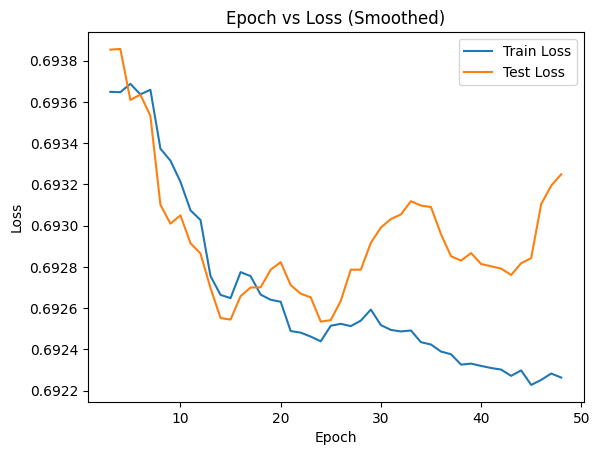

In [ ]:
import torch.utils.data as data
import matplotlib.pyplot as plt

# Lists to store training and test losses for each epoch
train_losses = []
test_losses = []

# Function to calculate accuracy
def accuracy(outputs, labels):
  preds = torch.round(outputs)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))


criterion = nn.BCELoss()
model = LSTMModel(input_dim=956, hidden_dim=200, layer_num=1, output_dim=1)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50

# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    epoch_acc = 0.0
    for X_batch, y_batch in train_loader:
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        print("-------------------")
        # Calculate accuracy on training set
        y_pred = model(X_train_all)
        train_loss = criterion(y_pred, Y_train_all)
        train_acc = accuracy(y_pred, Y_train_all)

        # Calculate accuracy on test set
        y_pred = model(X_test_all)
        test_loss = criterion(y_pred, Y_test_all)

        test_acc = accuracy(y_pred, Y_test_all)

    print("Epoch %d: train loss %.4f, test loss %.4f, train accuracy %.4f, test accuracy %.4f" % (epoch, train_loss, test_loss, train_acc, test_acc))

    # Append the losses to the lists
    train_losses.append(train_loss)
    test_losses.append(test_loss)

# Smooth the losses using a moving average
window_size = 5
train_losses_smoothed = np.convolve(train_losses, np.ones(window_size) / window_size, mode='valid')
test_losses_smoothed = np.convolve(test_losses, np.ones(window_size) / window_size, mode='valid')

# Plotting epoch vs training loss and test loss
epochs = range(window_size // 2 + 1, num_epochs - window_size // 2 + 1)
plt.plot(epochs, train_losses_smoothed, label='Train Loss')
plt.plot(epochs, test_losses_smoothed, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Loss (Smoothed)')
plt.legend()
plt.show()



In [ ]:
# import numpy as np

# RIGHT_EYE=[ 33, 7, 163, 144, 145, 153, 154, 155, 133, 173, 157, 158, 159, 160, 161 , 246 ]
# LEFT_EYE =[ 362, 382, 381, 380, 374, 373, 390, 249, 263, 466, 388, 387, 386, 385,384, 398 ]
# CLOSED_EYES_FRAME = 3
# BLINK_THRESHOLD = 5.5

# import random

# input_list_T = []
# input_list_F = []
# output_list_T = []
# output_list_F = []

# loop = 1
# for file_path in glob.glob(SAVE_NPY_PATH+"/*", recursive = True):
#   # Y Value
#   output = truthfulness[Path(file_path).stem]

#   # X Value
#   array = np.load(file_path)
#   # print("Original array shape:", array.shape)
#   ratioarray = blinkRatio(array, RIGHT_EYE, LEFT_EYE)
#   # print("Blink ratio array shape:", ratioarray.shape)

#   blink_chunks_array = npy_to_npychunks(ratioarray)

#   print(ratioarray.shape)

#   num_chunks = blink_chunks_array.shape[0]

#   if output == 1:
#     input_list_T.append(blink_chunks_array)
#     output_list_T += [output]*num_chunks
#   else:
#     input_list_F.append(blink_chunks_array)
#     output_list_F += [output]*num_chunks
#   print(f"# of Videos Processed: {loop}")
#   loop += 1


# X_T = np.vstack(input_list_T)
# X_F = np.vstack(input_list_F)
# Y_T = np.array(output_list_T).reshape(-1,1)
# Y_F = np.array(output_list_F).reshape(-1,1)



# X_T = torch.from_numpy(X_T).to(device)
# X_F = torch.from_numpy(X_F).to(device)
# Y_T = torch.from_numpy(Y_T).to(device)
# Y_F = torch.from_numpy(Y_F).to(device)

# X_T = X_T.float()
# X_F = X_F.float()
# Y_T = Y_T.float()
# Y_F = Y_F.float()

# print("X_T.shape", X_T.shape)
# print("X_F.shape", X_F.shape)
# print("Y_T.shape", Y_T.shape)
# print("Y_F.shape", Y_F.shape)

In [ ]:
import torch.utils.data as data

# Split the shuffled data into 80% Training, 20% Testing
train_dataset_T, val_dataset_T = torch.utils.data.random_split(data.TensorDataset(X_T, Y_T), [0.8, 0.2])
train_dataset_F, val_dataset_F = torch.utils.data.random_split(data.TensorDataset(X_F, Y_F), [0.8, 0.2])

train_dataset = data.ConcatDataset([train_dataset_T, train_dataset_F])
val_dataset = data.ConcatDataset([val_dataset_T, val_dataset_F])

print("Training Dataset Size:", len(train_dataset))
print("Testing Dataset Size:", len(val_dataset))
print()

train_loader = data.DataLoader(train_dataset, batch_size=50, shuffle=True)

total_train_samples = len(train_dataset)
count_train_ones = sum(1 for _, label in train_dataset if label == 1)
percentage_train_ones = (count_train_ones / total_train_samples) * 100
print("Percentage of Y that are Truths in train_dataset:", percentage_train_ones)


test_loader = data.DataLoader(val_dataset, batch_size=1, shuffle=False)

total_val_samples = len(val_dataset)
count_val_ones = sum(1 for _, label in val_dataset if label == 1)
percentage_val_ones = (count_val_ones / total_val_samples) * 100
print("Percentage of Y that are Truths in val_dataset:", percentage_val_ones)


X_train_all = []
Y_train_all = []


# Iterate over the train_loader to accumulate the entire dataset
for X_train, Y_train in train_loader:
    X_train_all.append(X_train)
    Y_train_all.append(Y_train)

X_test_all = []
Y_test_all = []

for X_test, Y_test in test_loader:
    X_test_all.append(X_test)
    Y_test_all.append(Y_test)

X_test_all = torch.cat(X_test_all, dim=0).to(device)
Y_test_all = torch.cat(Y_test_all, dim=0).to(device)

X_train_all = torch.cat(X_train_all, dim=0).to(device)
Y_train_all = torch.cat(Y_train_all, dim=0).to(device)

Training Dataset Size: 2048
Testing Dataset Size: 512

Percentage of Y that are Truths in train_dataset: 50.0
Percentage of Y that are Truths in val_dataset: 50.0


### Adding when it is a blink or not

In [ ]:
import numpy as np
import random

CLOSED_EYES_FRAME = 3
BLINK_THRESHOLD = 5.5

input_list_T = []
input_list_F = []
output_list_T = []
output_list_F = []

loop = 1
for file_path in glob.glob(SAVE_NPY_PATH+"/*", recursive = True):
  # Y Value
  output = truthfulness[Path(file_path).stem]

  # X Value
  array = np.load(file_path)

  ## Filter to just eye landmarks
  right_eye_landmarks = array[:, RIGHT_EYE, :]
  left_eye_landmarks = array[:, LEFT_EYE, :]
  combined_landmarks = np.concatenate((right_eye_landmarks, left_eye_landmarks), axis=1)

  ratioarray = blinkRatio(right_eye_landmarks, left_eye_landmarks)

  combined_array = add_dimension(combined_landmarks, ratioarray)

  print("Combined Array shape:", combined_array.shape)

  CEF_COUNTER = 0 #counter to track the number of consecutive frames in which a person's eyes are detected as closed
  TOTAL_BLINKS = 0
  blink_events = []

  # Assume ratioarray is an array containing the blink ratio for each frame
  for ratio in ratioarray:
      if ratio > BLINK_THRESHOLD: # If a frame blink ratio is above a threshold, the frame represents a blink event
          CEF_COUNTER += 1
          # Mark the frame as a blink frame
          blink_events.append(1)
      else:
          if CEF_COUNTER > CLOSED_EYES_FRAME: # If a frame blink ratio is below a threshold, the frame represents a blink event
              TOTAL_BLINKS += 1
              CEF_COUNTER = 0
          # Mark the frame as a non-blink frame
          blink_events.append(0)

  # After processing all ratios, if there are still frames at the end of the loop with closed eyes, they are counted as a blink
  if CEF_COUNTER > CLOSED_EYES_FRAME:
      TOTAL_BLINKS += 1

th
  # Convert blink_events to a numpy array
  blink_array = np.array(blink_events)
  print("Blink Array Shape",blink_array.shape)

  combined_array = add_dimension(combined_array, blink_array)
  print("Blink Array Combined Shape",combined_array.shape)

  array = combined_array.reshape(240, -1)
  print("Reshaped Array:",array.shape)
  array = npy_to_npychunks(array)
  print("Chunk Array",array.shape)
  num_chunks = array.shape[0]

  if output == 1:
    input_list_T.append(array)
    output_list_T += [output]*num_chunks
  else:
    input_list_F.append(array)
    output_list_F += [output]*num_chunks
  print(f"# of Videos Processed: {loop}")
  print("\n")
  loop += 1


X_T = np.vstack(input_list_T)
X_F = np.vstack(input_list_F)
Y_T = np.array(output_list_T).reshape(-1,1)
Y_F = np.array(output_list_F).reshape(-1,1)



X_T = torch.from_numpy(X_T).to(device)
X_F = torch.from_numpy(X_F).to(device)
Y_T = torch.from_numpy(Y_T).to(device)
Y_F = torch.from_numpy(Y_F).to(device)

X_T = X_T.float()
X_F = X_F.float()
Y_T = Y_T.float()
Y_F = Y_F.float()

print("X_T.shape", X_T.shape)
print("X_F.shape", X_F.shape)
print("Y_T.shape", Y_T.shape)
print("Y_F.shape", Y_F.shape)

Combined Array shape: (240, 32, 3)
Blink Array Shape (240,)
Blink Array Combined Shape (240, 32, 4)
Reshaped Array: (240, 128)
Chunk Array (8, 30, 128)
# of Videos Processed: 1


Combined Array shape: (240, 32, 3)
Blink Array Shape (240,)
Blink Array Combined Shape (240, 32, 4)
Reshaped Array: (240, 128)
Chunk Array (8, 30, 128)
# of Videos Processed: 2


Combined Array shape: (240, 32, 3)
Blink Array Shape (240,)
Blink Array Combined Shape (240, 32, 4)
Reshaped Array: (240, 128)
Chunk Array (8, 30, 128)
# of Videos Processed: 3


Combined Array shape: (240, 32, 3)
Blink Array Shape (240,)
Blink Array Combined Shape (240, 32, 4)
Reshaped Array: (240, 128)
Chunk Array (8, 30, 128)
# of Videos Processed: 4


Combined Array shape: (240, 32, 3)
Blink Array Shape (240,)
Blink Array Combined Shape (240, 32, 4)
Reshaped Array: (240, 128)
Chunk Array (8, 30, 128)
# of Videos Processed: 5


Combined Array shape: (240, 32, 3)
Blink Array Shape (240,)
Blink Array Combined Shape (240, 32, 4)
Resha

## Iris

### Left and Right Eye/Iris Facial Landmarks each with  XY coordinates

In [ ]:
import random

input_list_T = []
input_list_F = []
output_list_T = []
output_list_F = []

loop = 1
for file_path in glob.glob(SAVE_NPY_PATH+"/*", recursive = True):
  # Y Value
  output = truthfulness[Path(file_path).stem]

  # X Value
  array = np.load(file_path)
  print(array.shape)

  right_eye_landmarks = array[:, RIGHT_EYE, :]
  left_eye_landmarks = array[:, LEFT_EYE, :]
  right_iris_landmarks = array[:, RIGHT_IRIS, :]
  left_iris_landmarks = array[:, LEFT_IRIS, :]

  combined_landmarks = np.concatenate((right_eye_landmarks, left_eye_landmarks, right_iris_landmarks, left_iris_landmarks), axis=1)
  print(combined_landmarks.shape)

  array = combined_landmarks.reshape(240, -1)
  # print(array.shape)

  array = npy_to_npychunks(array)
  print(array.shape)
  num_chunks = array.shape[0]

  if output == 1:
    input_list_T.append(array)
    output_list_T += [output]*num_chunks
  else:
    input_list_F.append(array)
    output_list_F += [output]*num_chunks
  print(f"# of Videos Processed: {loop}")
  loop += 1


X_T = np.vstack(input_list_T)
X_F = np.vstack(input_list_F)
Y_T = np.array(output_list_T).reshape(-1,1)
Y_F = np.array(output_list_F).reshape(-1,1)



X_T = torch.from_numpy(X_T).to(device)
X_F = torch.from_numpy(X_F).to(device)
Y_T = torch.from_numpy(Y_T).to(device)
Y_F = torch.from_numpy(Y_F).to(device)

X_T = X_T.float()
X_F = X_F.float()
Y_T = Y_T.float()
Y_F = Y_F.float()

print("X_T.shape", X_T.shape)
print("X_F.shape", X_F.shape)
print("Y_T.shape", Y_T.shape)
print("Y_F.shape", Y_F.shape)

(240, 478, 2)
(240, 40, 2)
(8, 30, 80)
# of Videos Processed: 1
(240, 478, 2)
(240, 40, 2)
(8, 30, 80)
# of Videos Processed: 2
(240, 478, 2)
(240, 40, 2)
(8, 30, 80)
# of Videos Processed: 3
(240, 478, 2)
(240, 40, 2)
(8, 30, 80)
# of Videos Processed: 4
(240, 478, 2)
(240, 40, 2)
(8, 30, 80)
# of Videos Processed: 5
(240, 478, 2)
(240, 40, 2)
(8, 30, 80)
# of Videos Processed: 6
(240, 478, 2)
(240, 40, 2)
(8, 30, 80)
# of Videos Processed: 7
(240, 478, 2)
(240, 40, 2)
(8, 30, 80)
# of Videos Processed: 8
(240, 478, 2)
(240, 40, 2)
(8, 30, 80)
# of Videos Processed: 9
(240, 478, 2)
(240, 40, 2)
(8, 30, 80)
# of Videos Processed: 10
(240, 478, 2)
(240, 40, 2)
(8, 30, 80)
# of Videos Processed: 11
(240, 478, 2)
(240, 40, 2)
(8, 30, 80)
# of Videos Processed: 12
(240, 478, 2)
(240, 40, 2)
(8, 30, 80)
# of Videos Processed: 13
(240, 478, 2)
(240, 40, 2)
(8, 30, 80)
# of Videos Processed: 14
(240, 478, 2)
(240, 40, 2)
(8, 30, 80)
# of Videos Processed: 15
(240, 478, 2)
(240, 40, 2)
(8, 30,

In [ ]:
import torch.utils.data as data

# Split the shuffled data into 80% Training, 20% Testing
train_dataset_T, val_dataset_T = torch.utils.data.random_split(data.TensorDataset(X_T, Y_T), [0.8, 0.2])
train_dataset_F, val_dataset_F = torch.utils.data.random_split(data.TensorDataset(X_F, Y_F), [0.8, 0.2])

train_dataset = data.ConcatDataset([train_dataset_T, train_dataset_F])
val_dataset = data.ConcatDataset([val_dataset_T, val_dataset_F])

print("Training Dataset Size:", len(train_dataset))
print("Testing Dataset Size:", len(val_dataset))
print()

train_loader = data.DataLoader(train_dataset, batch_size=50, shuffle=True)

total_train_samples = len(train_dataset)
count_train_ones = sum(1 for _, label in train_dataset if label == 1)
percentage_train_ones = (count_train_ones / total_train_samples) * 100
print("Percentage of Y that are Truths in train_dataset:", percentage_train_ones)


test_loader = data.DataLoader(val_dataset, batch_size=1, shuffle=False)

total_val_samples = len(val_dataset)
count_val_ones = sum(1 for _, label in val_dataset if label == 1)
percentage_val_ones = (count_val_ones / total_val_samples) * 100
print("Percentage of Y that are Truths in val_dataset:", percentage_val_ones)


X_train_all = []
Y_train_all = []


# Iterate over the train_loader to accumulate the entire dataset
for X_train, Y_train in train_loader:
    X_train_all.append(X_train)
    Y_train_all.append(Y_train)

X_test_all = []
Y_test_all = []

for X_test, Y_test in test_loader:
    X_test_all.append(X_test)
    Y_test_all.append(Y_test)

X_test_all = torch.cat(X_test_all, dim=0).to(device)
Y_test_all = torch.cat(Y_test_all, dim=0).to(device)

X_train_all = torch.cat(X_train_all, dim=0).to(device)
Y_train_all = torch.cat(Y_train_all, dim=0).to(device)

Training Dataset Size: 2048
Testing Dataset Size: 512

Percentage of Y that are Truths in train_dataset: 50.0
Percentage of Y that are Truths in val_dataset: 50.0


-------------------
Epoch 0: train loss 0.6949, test loss 0.6951, train accuracy 0.5000, test accuracy 0.5000
-------------------
Epoch 1: train loss 0.6933, test loss 0.6938, train accuracy 0.5000, test accuracy 0.5000
-------------------
Epoch 2: train loss 0.6931, test loss 0.6936, train accuracy 0.4990, test accuracy 0.5059
-------------------
Epoch 3: train loss 0.6935, test loss 0.6939, train accuracy 0.5000, test accuracy 0.5000
-------------------
Epoch 4: train loss 0.6931, test loss 0.6935, train accuracy 0.5024, test accuracy 0.4961
-------------------
Epoch 5: train loss 0.6931, test loss 0.6936, train accuracy 0.5024, test accuracy 0.4961
-------------------
Epoch 6: train loss 0.6933, test loss 0.6937, train accuracy 0.5000, test accuracy 0.5000
-------------------
Epoch 7: train loss 0.6933, test loss 0.6937, train accuracy 0.5000, test accuracy 0.5000
-------------------
Epoch 8: train loss 0.6931, test loss 0.6935, train accuracy 0.5020, test accuracy 0.5000
----------

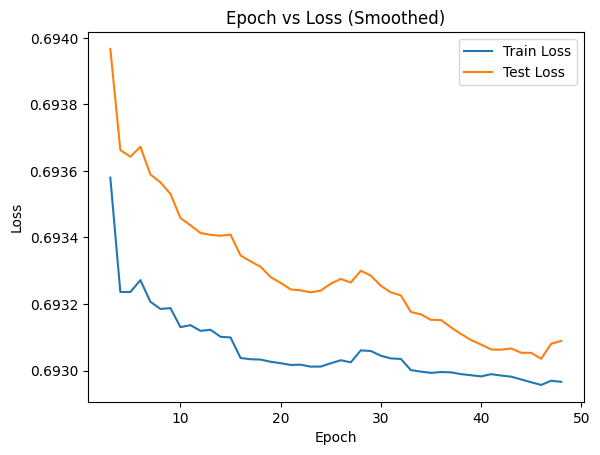

In [ ]:
import torch.utils.data as data
import matplotlib.pyplot as plt

# Lists to store training and test losses for each epoch
train_losses = []
test_losses = []

# Function to calculate accuracy
def accuracy(outputs, labels):
  preds = torch.round(outputs)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))


criterion = nn.BCELoss()
model = LSTMModel(input_dim=956, hidden_dim=200, layer_num=1, output_dim=1)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50

# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    epoch_acc = 0.0
    for X_batch, y_batch in train_loader:
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        print("-------------------")
        # Calculate accuracy on training set
        y_pred = model(X_train_all)
        train_loss = criterion(y_pred, Y_train_all)
        train_acc = accuracy(y_pred, Y_train_all)

        # Calculate accuracy on test set
        y_pred = model(X_test_all)
        test_loss = criterion(y_pred, Y_test_all)

        test_acc = accuracy(y_pred, Y_test_all)

    print("Epoch %d: train loss %.4f, test loss %.4f, train accuracy %.4f, test accuracy %.4f" % (epoch, train_loss, test_loss, train_acc, test_acc))

    # Append the losses to the lists
    train_losses.append(train_loss)
    test_losses.append(test_loss)

# Smooth the losses using a moving average
window_size = 5
train_losses_smoothed = np.convolve(train_losses, np.ones(window_size) / window_size, mode='valid')
test_losses_smoothed = np.convolve(test_losses, np.ones(window_size) / window_size, mode='valid')

# Plotting epoch vs training loss and test loss
epochs = range(window_size // 2 + 1, num_epochs - window_size // 2 + 1)
plt.plot(epochs, train_losses_smoothed, label='Train Loss')
plt.plot(epochs, test_losses_smoothed, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Loss (Smoothed)')
plt.legend()
plt.show()



### Iris position

Note: This code does not work because there are some debugging issues maybe to do with the

In [ ]:
def iris_position(iris_center, right_point, left_point):
    center_to_right_dist = euclideanDistance(iris_center, right_point)
    total_distance = euclideanDistance(right_point, left_point)

    # print("center to right:",center_to_right_dist)
    # print("center to right:",center_to_right_dist)
    # print("total distance:",total_distance)

    ratio = center_to_right_dist/total_distance
    iris_position =""
    if ratio <= 0.42:
        iris_position="right"
    elif ratio > 0.42 and ratio <= 0.57:
        iris_position="center"
    else:
        iris_position = "left"
    # print(iris_position, ratio)
    # print("\n")
    return iris_position, ratio

In [ ]:
import random

input_list_T = []
input_list_F = []
output_list_T = []
output_list_F = []

loop = 1
for file_path in glob.glob(SAVE_NPY_PATH+"/*", recursive = True):
  # Y Value
  output = truthfulness[Path(file_path).stem]

  # X Value
  array = np.load(file_path)

  right_iris_landmarks = array[:, RIGHT_IRIS, :]
  left_iris_landmarks = array[:, LEFT_IRIS, :]

  # combined_landmarks = np.concatenate((right_iris_landmarks, left_iris_landmarks), axis=1)
  # print(combined_landmarks.shape)

  LEFT_IRIS = [474, 475, 476, 477]
  RIGHT_IRIS = [469, 470, 471, 472]

  L_H_LEFT = [33]     # right eye most right reference point
  L_H_RIGHT = [133]   # right eye most left reference point
  R_H_LEFT = [362]    # left eye most right reference point
  R_H_RIGHT = [263]   # left eye most left reference point

  new_array = []
  for frame in array:

    right_iris_center = np.mean(frame[RIGHT_IRIS, :], axis=0)
    right_eye_right_corner = frame[R_H_RIGHT, :].flatten()
    right_eye_left_corner = frame[R_H_LEFT, :].flatten()

    left_iris_center = np.mean(frame[LEFT_IRIS, :], axis=0)
    left_eye_right_corner = frame[L_H_RIGHT, :].flatten()
    left_eye_left_corner = frame[L_H_LEFT, :].flatten()
    print(frame[RIGHT_IRIS, :])
    print(right_iris_center, right_eye_right_corner, right_eye_left_corner)
    iris_pos_right, ratio_right = iris_position(right_iris_center, right_eye_right_corner, right_eye_left_corner)


    iris_pos_left, ratio_left = iris_position(left_iris_center, left_eye_left_corner, left_eye_right_corner)

    new_array.append([iris_pos_right, ratio_right, iris_pos_left, ratio_left])


    array = np.array(new_array)
    print(array.shape)
    print("\n")
    break
#   array = combined_landmarks.reshape(240, -1)
#   # print(array.shape)

#   array = npy_to_npychunks(array)
#   print(array.shape)
#   num_chunks = array.shape[0]

#   if output == 1:
#     input_list_T.append([iris_pos_right, ratio_right, iris_pos_left, ratio_left])
#     output_list_T += [output]*num_chunks
#   else:
#     input_list_F.append([iris_pos_right, ratio_right, iris_pos_left, ratio_left])
#     output_list_F += [output]*num_chunks
#   print(f"# of Videos Processed: {loop}")
#   loop += 1


# X_T = np.vstack(input_list_T)
# X_F = np.vstack(input_list_F)
# Y_T = np.array(output_list_T).reshape(-1,1)
# Y_F = np.array(output_list_F).reshape(-1,1)



# X_T = torch.from_numpy(X_T).to(device)
# X_F = torch.from_numpy(X_F).to(device)
# Y_T = torch.from_numpy(Y_T).to(device)
# Y_F = torch.from_numpy(Y_F).to(device)

# X_T = X_T.float()
# X_F = X_F.float()
# Y_T = Y_T.float()
# Y_F = Y_F.float()

# print("X_T.shape", X_T.shape)
# print("X_F.shape", X_F.shape)
# print("Y_T.shape", Y_T.shape)
# print("Y_F.shape", Y_F.shape)

[[0.37434083 0.66189331]
 [0.35355479 0.63791764]
 [0.33229277 0.66116595]
 [0.35285938 0.68634593]]
[0.35326194 0.66183071] [0.60247529 0.6616264 ] [0.51070148 0.67622483]
(11219, 4)


[[0.20325924 0.1942358 ]
 [0.19352272 0.17770585]
 [0.18081099 0.19228694]
 [0.19000381 0.20955542]]
[0.19189919 0.193446  ] [0.3898609  0.22079991] [0.32218811 0.22348054]
(11220, 4)


[[0.49146649 0.47969961]
 [0.4811281  0.46940535]
 [0.47205406 0.48134133]
 [0.48226002 0.49194247]]
[0.48172717 0.48059719] [0.59697217 0.47159511] [0.55412918 0.47833928]
(11221, 4)


[[0.49758831 0.36400697]
 [0.48651725 0.35201347]
 [0.47595483 0.36354619]
 [0.48697698 0.37567046]]
[0.48675934 0.36380927] [0.62000442 0.36762273] [0.57636273 0.36773169]
(11222, 4)


[[0.52276462 0.14443442]
 [0.51180702 0.13001651]
 [0.49990383 0.14306845]
 [0.51060849 0.15819354]]
[0.51127099 0.14392823] [0.66128761 0.15292093] [0.60892081 0.15837643]
(11223, 4)


[[0.4881331  0.52755994]
 [0.47580284 0.51597631]
 [0.4654758  0.52986

In [ ]:
?

# End